In [1]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

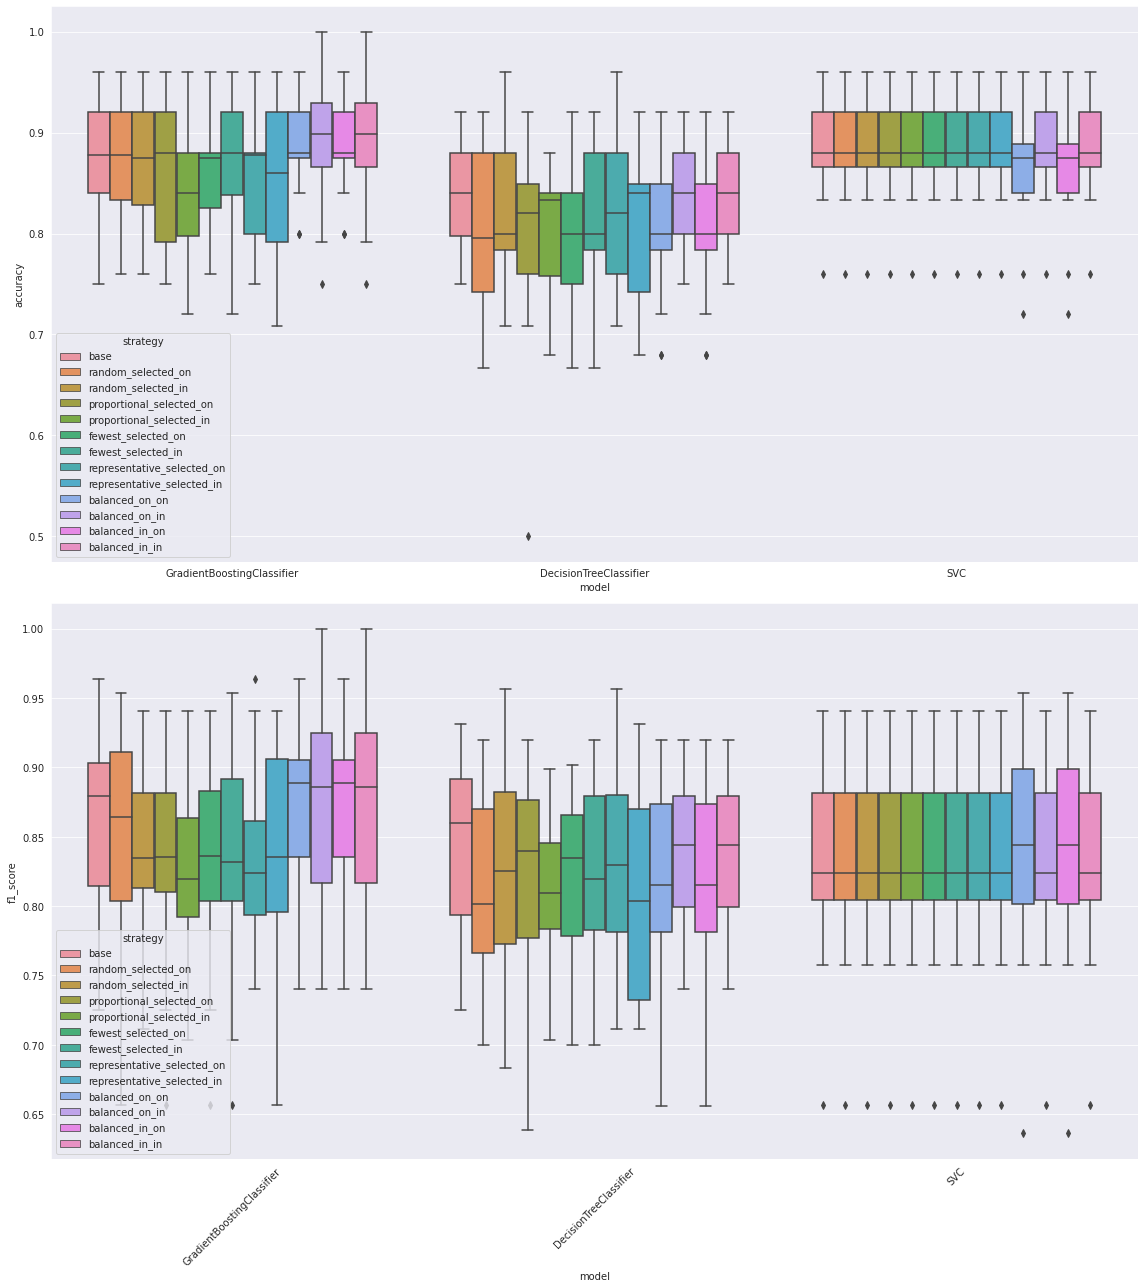

In [2]:
traffic_results = pd.read_csv('./traffic_results.csv')
fig, ax = plt.subplots(2, 1, figsize=(16,18))
sns.boxplot(traffic_results, x='model', y='accuracy', hue='strategy', ax=ax[0])
sns.boxplot(traffic_results, x='model', y='f1_score', hue='strategy', ax=ax[1])
plt.xticks(rotation=45)
plt.tight_layout()

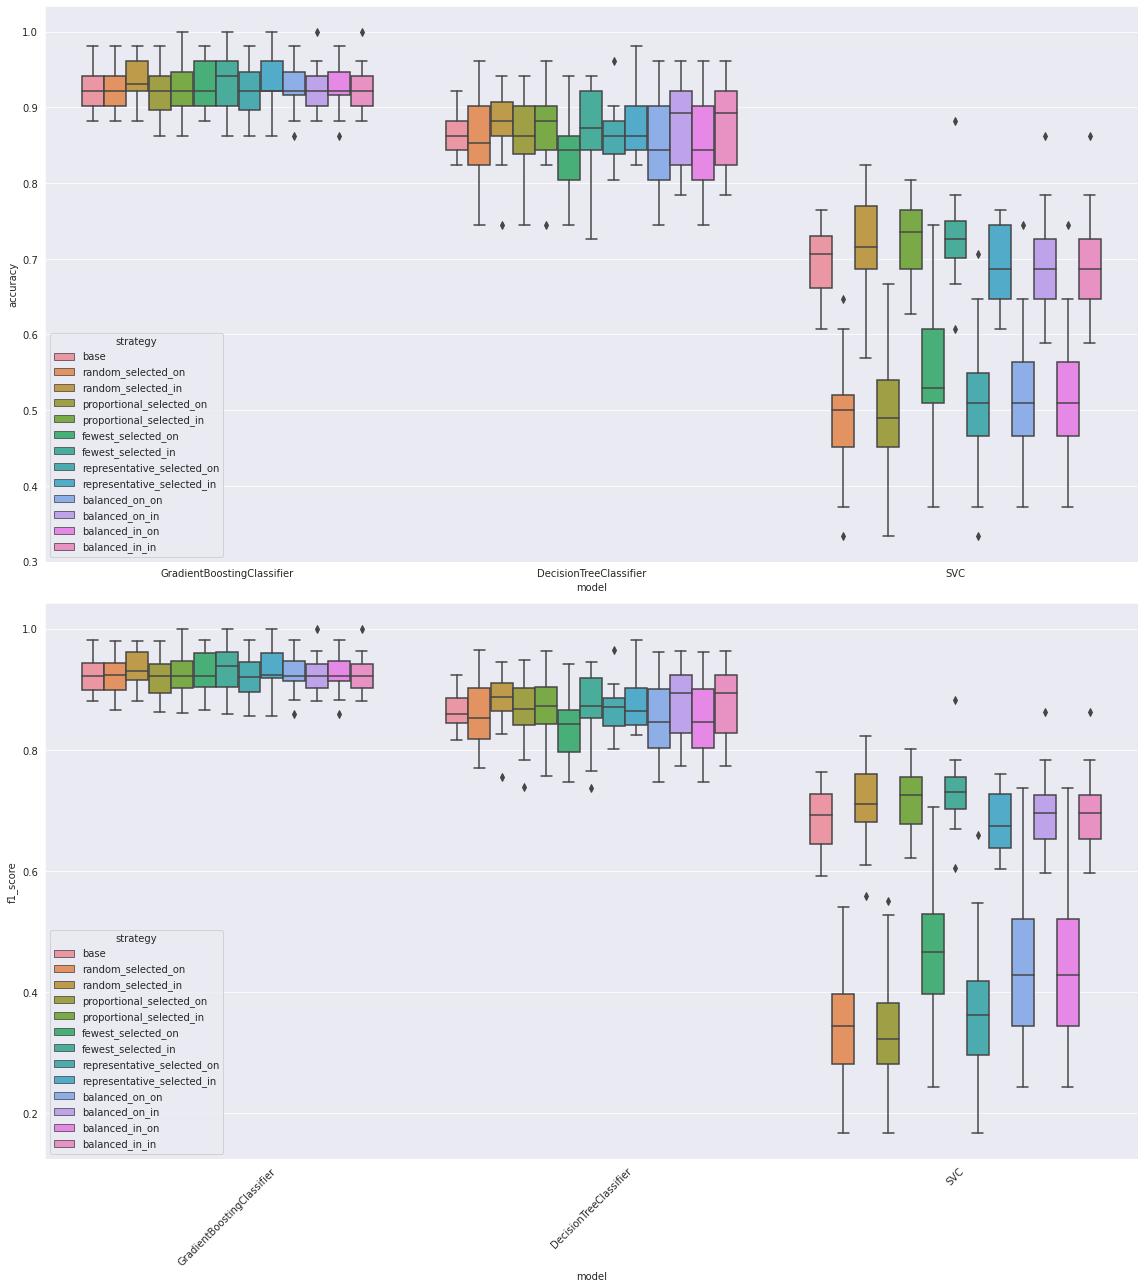

In [3]:
starkey_results = pd.read_csv('./starkey_results.csv')
fig1, ax1 = plt.subplots(2, 1, figsize=(16, 18))
sns.boxplot(starkey_results, x='model', y='accuracy', hue='strategy', ax=ax1[0])
sns.boxplot(starkey_results, x='model', y='f1_score', hue='strategy', ax=ax1[1])
plt.xticks(rotation=45)
plt.tight_layout()